In [269]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from typing import List
from tqdm import tqdm


%matplotlib inline

## Считаем данные соревнования от MTS по RecSys

In [270]:
df = pd.read_csv('interactions.csv')
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [271]:
df.user_id.nunique(), df.item_id.nunique()

(962179, 15706)

In [272]:
df.last_watch_dt.min(), df.last_watch_dt.max()

('2021-03-13', '2021-08-22')

In [273]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
736952,9373,13218,150,2787,62.0
2190107,68961,12192,117,7346,10.0
333802,110030,16340,150,61,2.0
4470388,999751,1189,138,1830,38.0
3188986,465774,6192,156,235243,41.0


## Popular bias

<Axes: xlabel='index'>

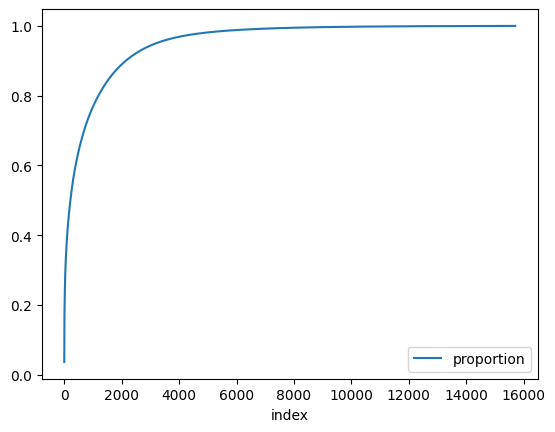

In [274]:
g = df.item_id.value_counts(True).cumsum().reset_index().reset_index()
g.plot(x='index', y='proportion')

<Axes: xlabel='index'>

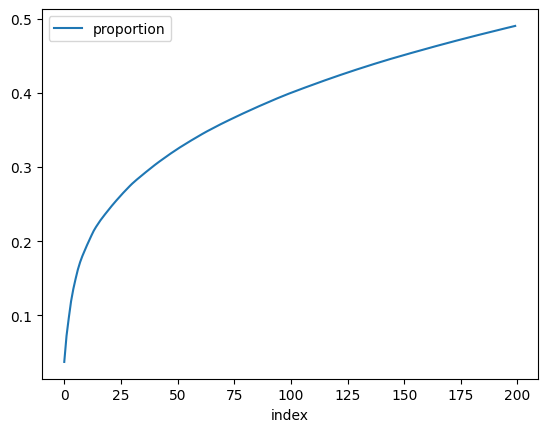

In [275]:
g = df.item_id.value_counts(True)[:200].cumsum().reset_index().reset_index()
g.plot(x='index', y='proportion')

## Популярность айтема по времени

<Axes: >

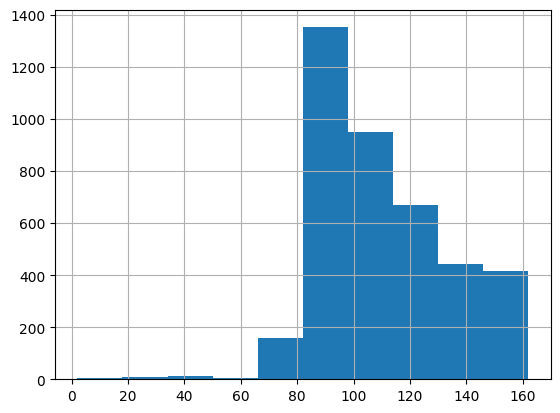

In [279]:
popular_items = df.item_id.value_counts()[:300].index.tolist()

sampled_id = np.random.choice(popular_items)

interactions = df.loc[df.item_id==sampled_id].copy()
interactions.last_watch_dt.hist()

In [281]:
temp = df.groupby('item_id').agg({'last_watch_dt':'max'}).reset_index()
temp = temp.loc[temp.item_id.isin(popular_items)].copy()
temp = temp.sort_values(by='last_watch_dt')
temp.head()

,item_id,last_watch_dt
6751,7107,87
8359,8801,140
11826,12463,141
4486,4716,141
14,14,162


<Axes: >

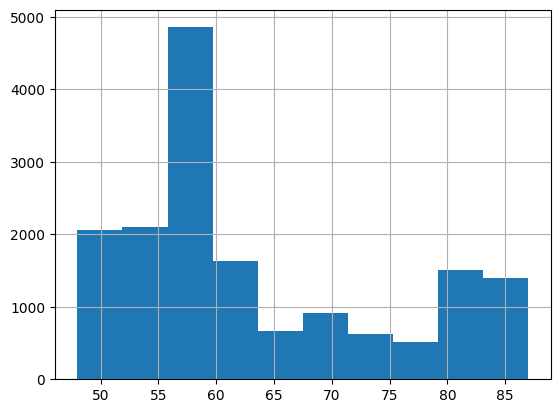

In [282]:
interactions = df.loc[df.item_id==7107].copy()
interactions.last_watch_dt.hist()

Этот айтем не встретится в тесте скорее всего, хоть он и популярный.

## Сделаем протокол тестирования

<Axes: >

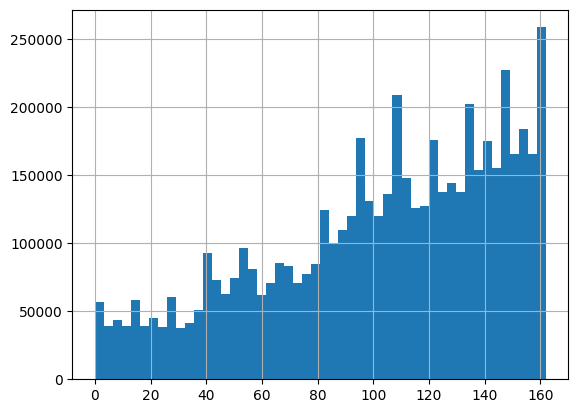

In [283]:
df.last_watch_dt.hist(bins=50)

In [284]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [233]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

## Теперь переведем к соединенному датасету все

In [285]:
n_users = 5000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users


In [287]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
27,841859,3935,94,8862,100.0
230,500077,3819,130,961,8.0
349,622633,6957,140,1407,2.0
577,661386,6195,151,49,0.0
619,72137,3784,138,6,0.0


In [286]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, 
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

,user_id,train_interactions
0,175,"[(13865, 100), (9728, 109), (10440, 117), (128..."
1,315,"[(3792, 58), (11697, 58), (8636, 78), (9070, 8..."
2,581,"[(10440, 127)]"
3,733,"[(4946, 147), (5693, 147), (11769, 147), (1189..."
4,860,"[(4495, 138), (9728, 138), (3734, 143), (142, ..."


In [289]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,175,"[(13865, 100), (9728, 109), (10440, 117), (128...","[(15297, 153)]"
1,315,"[(3792, 58), (11697, 58), (8636, 78), (9070, 8...","[(6945, 154), (1978, 156)]"
2,581,"[(10440, 127)]","[(9728, 158), (7269, 158)]"
3,733,"[(4946, 147), (5693, 147), (11769, 147), (1189...","[(11131, 153), (3363, 154), (15297, 154), (473..."
4,860,"[(4495, 138), (9728, 138), (3734, 143), (142, ...","[(10544, 153), (15297, 153), (1712, 161), (644..."


In [290]:
def ndcg_metric(gt_items, predicted):
    
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)

    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores):
    return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
                  dtype=np.float64)


def recall_metric(gt_items, predicted):
    
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt



def evaluate_recommender(df, model_preds, gt_col='test_interactions', topn=10):
    
    metric_values = []
    
    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        metric_values.append((ndcg_metric(gt_items, row[model_preds]),
                              recall_metric(gt_items, row[model_preds])))
        
    return {'ndcg':np.mean([x[0] for x in metric_values]),
            'recall':np.mean([x[1] for x in metric_values])}
            


In [291]:
def get_metrics(df, model_preds, gt_col='test_interactions', topn=10):
    
    metric_values = []
    
    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        metric_values.append((ndcg_metric(gt_items, row[model_preds]),
                              recall_metric(gt_items, row[model_preds])))
        
    return metric_values
        

In [298]:
class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=100):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()  

,user_id,train_interactions,test_interactions,random_recs
0,175,"[(13865, 100), (9728, 109), (10440, 117), (128...","[(15297, 153)]","[7560, 4590, 8442]"
1,315,"[(3792, 58), (11697, 58), (8636, 78), (9070, 8...","[(6945, 154), (1978, 156)]","[7560, 4590, 8442]"
2,581,"[(10440, 127)]","[(9728, 158), (7269, 158)]","[7560, 4590, 8442]"
3,733,"[(4946, 147), (5693, 147), (11769, 147), (1189...","[(11131, 153), (3363, 154), (15297, 154), (473...","[7560, 4590, 8442]"
4,860,"[(4495, 138), (9728, 138), (3734, 143), (142, ...","[(10544, 153), (15297, 153), (1712, 161), (644...","[7560, 4590, 8442]"


In [299]:
evaluate_recommender(joined, model_preds='random_recs')

{'ndcg': 0.00015280197828134527, 'recall': 7.5e-05}

In [302]:
df[['user_id','item_id']].value_counts()

user_id  item_id
0        6006       1
732072   12318      1
         3804       1
         3343       1
732071   15297      1
                   ..
366421   14317      1
         13865      1
         13243      1
         13159      1
1097557  15297      1
Name: count, Length: 5476251, dtype: int64

In [303]:
class TopPopular:

    def __init__(self):

        self.trained = False
    
    def fit(self, df, col='train_interactions'):
        
        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1
                    
        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
        
        self.recommenations = [x[0] for x in counts]
        self.trained = True
        
    def predict(self, df, topn=100)  -> List[np.ndarray]:
        
        assert self.trained
        return [self.recommenations[:topn]]*len(df)

    
toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()       

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,175,"[(13865, 100), (9728, 109), (10440, 117), (128...","[(15297, 153)]","[7560, 4590, 8442]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
1,315,"[(3792, 58), (11697, 58), (8636, 78), (9070, 8...","[(6945, 154), (1978, 156)]","[7560, 4590, 8442]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
2,581,"[(10440, 127)]","[(9728, 158), (7269, 158)]","[7560, 4590, 8442]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
3,733,"[(4946, 147), (5693, 147), (11769, 147), (1189...","[(11131, 153), (3363, 154), (15297, 154), (473...","[7560, 4590, 8442]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
4,860,"[(4495, 138), (9728, 138), (3734, 143), (142, ...","[(10544, 153), (15297, 153), (1712, 161), (644...","[7560, 4590, 8442]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."


In [304]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'ndcg': 0.47828402489761757, 'recall': 0.3606713485967016}

In [306]:
class ModifiedTopPopular(TopPopular):

    def __init__(self):

        self.trained = False

        
    def predict(self, df, topn=100)  -> List[np.ndarray]:
        
        assert self.trained
        
        all_recs = []
        
        for idx, row in df.iterrows():
            
            user_recs = []
            
            user_interactions = set([x[0] for x in row['train_interactions']])
            
            for elem in self.recommenations:
                if elem not in user_interactions:
                    user_recs.append(elem)
                    
                if len(user_recs) == topn:
                    break
                    
            all_recs.append(user_recs)
                
        return all_recs

    
toppop = ModifiedTopPopular()
toppop.fit(joined)
joined['toppopular_recs_filtered'] = toppop.predict(joined)
joined.head()       

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,toppopular_recs_filtered
0,175,"[(13865, 100), (9728, 109), (10440, 117), (128...","[(15297, 153)]","[7560, 4590, 8442]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[15297, 3734, 4151, 4880, 2657, 142, 12192, 99..."
1,315,"[(3792, 58), (11697, 58), (8636, 78), (9070, 8...","[(6945, 154), (1978, 156)]","[7560, 4590, 8442]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[9728, 15297, 13865, 3734, 4151, 4880, 142, 12..."
2,581,"[(10440, 127)]","[(9728, 158), (7269, 158)]","[7560, 4590, 8442]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[9728, 15297, 13865, 3734, 4151, 4880, 2657, 1..."
3,733,"[(4946, 147), (5693, 147), (11769, 147), (1189...","[(11131, 153), (3363, 154), (15297, 154), (473...","[7560, 4590, 8442]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
4,860,"[(4495, 138), (9728, 138), (3734, 143), (142, ...","[(10544, 153), (15297, 153), (1712, 161), (644...","[7560, 4590, 8442]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 15297, 13865, 4151, 4880, 2657, 12192,..."


In [307]:
evaluate_recommender(joined, model_preds='toppopular_recs_filtered')

{'ndcg': 0.48344034959635535, 'recall': 0.365494793034093}

## Теперь выкинем айтемы, которые не показывались в момент перед тестом

In [309]:
ld = train_df.groupby('item_id').agg({'last_watch_dt':'max'}).reset_index()
validated_items = ld.loc[ld.last_watch_dt == 152].item_id.unique()

#validated_items

In [310]:
ld.max()

item_id          16511
last_watch_dt      152
dtype: int64

In [311]:
class ActualTopPopular(TopPopular):

    def __init__(self):

        self.trained = False

        
    def predict(self, df, only_items=None, topn=100)  -> List[np.ndarray]:
        
        assert self.trained

        only_items = set(only_items)
        
        all_recs = []
        
        for idx, row in df.iterrows():
            
            user_recs = []
            
            user_interactions = set([x[0] for x in row['train_interactions']])
            
            for elem in self.recommenations:
                if elem not in user_interactions and elem in only_items:
                    user_recs.append(elem)
                    
                if len(user_recs) == topn:
                    break
                    
            all_recs.append(user_recs)
                
        return all_recs

    
toppop = ActualTopPopular()
toppop.fit(joined)
joined['actual_toppop'] = toppop.predict(joined, only_items=validated_items)
joined.head()       

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,toppopular_recs_filtered,actual_toppop
0,175,"[(13865, 100), (9728, 109), (10440, 117), (128...","[(15297, 153)]","[7560, 4590, 8442]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[15297, 3734, 4151, 4880, 2657, 142, 12192, 99...","[15297, 3734, 4151, 4880, 2657, 142, 12192, 99..."
1,315,"[(3792, 58), (11697, 58), (8636, 78), (9070, 8...","[(6945, 154), (1978, 156)]","[7560, 4590, 8442]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[9728, 15297, 13865, 3734, 4151, 4880, 142, 12...","[9728, 15297, 13865, 3734, 4151, 4880, 142, 12..."
2,581,"[(10440, 127)]","[(9728, 158), (7269, 158)]","[7560, 4590, 8442]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[9728, 15297, 13865, 3734, 4151, 4880, 2657, 1...","[9728, 15297, 13865, 3734, 4151, 4880, 2657, 1..."
3,733,"[(4946, 147), (5693, 147), (11769, 147), (1189...","[(11131, 153), (3363, 154), (15297, 154), (473...","[7560, 4590, 8442]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
4,860,"[(4495, 138), (9728, 138), (3734, 143), (142, ...","[(10544, 153), (15297, 153), (1712, 161), (644...","[7560, 4590, 8442]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 15297, 13865, 4151, 4880, 2657, 12192,...","[10440, 15297, 13865, 4151, 4880, 2657, 12192,..."


In [312]:
evaluate_recommender(joined, model_preds='actual_toppop')

{'ndcg': 0.4893428956060403, 'recall': 0.3701190946971148}

## Сработает ли тут Toppersonal?

In [249]:
df[['user_id','item_id']].value_counts()[:5]

user_id  item_id
0        6006       1
732072   12318      1
         3804       1
         3343       1
732071   15297      1
Name: count, dtype: int64

## Построим EASE

In [313]:
item2id = {k:v for v, k in enumerate(train_df.item_id.unique())}
user2id = {k:v for v, k in enumerate(train_df.user_id.unique())}

id2item = {k:v for v, k in item2id.items()}
id2user = {k:v for v, k in user2id.items()}

train_df['user_id'] = train_df.user_id.apply(lambda x: user2id[x])
train_df['item_id'] = train_df.item_id.apply(lambda x: item2id[x])

train_df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
2612932,723,244,56,2755,35.0
2751841,945,347,136,1110,20.0
3723976,834,1055,151,4890,93.0
422692,93,891,56,171,5.0
4845310,3817,1151,143,730,9.0


In [315]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(train_df.shape[0]), (train_df['user_id'], train_df['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<5000x5352 sparse matrix of type '<class 'numpy.float64'>'
	with 59545 stored elements in COOrdinate format>

In [321]:
%%time

# Обучаем конечную модель
# Мы взяли реализацию из RecBole
# 
def fit_ease(X, reg_weight=100):
    
 # gram matrix
    G = X.T @ X

    # add reg to diagonal
    G += reg_weight * sps.identity(G.shape[0])

    # convert to dense because inverse will be dense
    G = G.todense()

    # invert. this takes most of the time
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    # zero out diag
    np.fill_diagonal(B, 0.)
    
    return B

w = fit_ease(matrix)

CPU times: user 18.3 s, sys: 807 ms, total: 19.1 s
Wall time: 3.91 s


In [322]:
w.shape

(5352, 5352)

In [323]:
def get_preds(x, item2id, id2item):

    user_items = [t[0] for t in x]
    encoded = [item2id[t] for t in user_items if t in item2id]

    # Составляем вектор интеракций человека
    vector = np.zeros(len(item2id))
    vector[encoded] = 1

    vector = sps.csr_matrix(vector)

    preds = np.array(vector.dot(w))[0]#.toarray()
    preds[encoded==1] = -np.inf

    ranks = np.argsort(-preds)
    decoded = [id2item[t] for t in ranks][:100]
    
    return decoded


joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,toppopular_recs_filtered,actual_toppop,ease_preds
0,175,"[(13865, 100), (9728, 109), (10440, 117), (128...","[(15297, 153)]","[7560, 4590, 8442]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[15297, 3734, 4151, 4880, 2657, 142, 12192, 99...","[15297, 3734, 4151, 4880, 2657, 142, 12192, 99...","[9728, 13865, 15297, 10440, 3734, 9996, 12995,..."
1,315,"[(3792, 58), (11697, 58), (8636, 78), (9070, 8...","[(6945, 154), (1978, 156)]","[7560, 4590, 8442]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[9728, 15297, 13865, 3734, 4151, 4880, 142, 12...","[9728, 15297, 13865, 3734, 4151, 4880, 142, 12...","[15297, 10440, 4151, 13865, 9728, 2657, 142, 9..."
2,581,"[(10440, 127)]","[(9728, 158), (7269, 158)]","[7560, 4590, 8442]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[9728, 15297, 13865, 3734, 4151, 4880, 2657, 1...","[9728, 15297, 13865, 3734, 4151, 4880, 2657, 1...","[15297, 9728, 13865, 2657, 9996, 4151, 4880, 1..."
3,733,"[(4946, 147), (5693, 147), (11769, 147), (1189...","[(11131, 153), (3363, 154), (15297, 154), (473...","[7560, 4590, 8442]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 9728, 13865, 12192, 15297, 5434, 11769..."
4,860,"[(4495, 138), (9728, 138), (3734, 143), (142, ...","[(10544, 153), (15297, 153), (1712, 161), (644...","[7560, 4590, 8442]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 15297, 13865, 4151, 4880, 2657, 12192,...","[10440, 15297, 13865, 4151, 4880, 2657, 12192,...","[13865, 15297, 10440, 4151, 9728, 4880, 3734, ..."


In [325]:
evaluate_recommender(joined, model_preds='ease_preds') # lambda 100

{'ndcg': 0.47590992690179174, 'recall': 0.3542604483788808}

In [319]:
evaluate_recommender(pd.concat([joined, []]), model_preds='ease_preds') # lambda = 1000

{'ndcg': 0.50781990916091, 'recall': 0.3889052160186385}